# Pr8-3: OpticalFlow

## 必要なライブラリのインストール

In [8]:
# プログレスバー用ライブラリのインストール
from fastprogress import progress_bar

# 動画入出力に使うライブラリ
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Colab上での出力用ライブラリ
from IPython.display import HTML
import base64
import io

## 表示・入出力用の補助関数

In [2]:
def display_video(video_file):
  cap = cv2.VideoCapture(video_file)
  w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
  h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
  cap.release()
  video = io.open(video_file, 'r+b').read()
  encoded = base64.b64encode(video)
  html_code = '''<video width="70%" height="70%" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''
 
  return(HTML(data=html_code.format(encoded.decode('ascii'))))


def read_scale(cap, scale):
  ret, I = cap.read()
  if ret==False:
    return False, None

  I = cv2.resize(I, dsize=None, fx=scale, fy=scale)
  return ret, I

## 疎なOptical Flowのひな形コード

今回の演習では，中身の詳細までは追わなくても良いです．
（実際にどうコードを書くか興味がある人は，覗いてみると良いです．）

### cv2.calcOpticalFlowPyrLK

Lucas-Kanade 法による疎なOptical Flow

```
# 初期フレームでの特徴点の抽出
p1 = cv2.goodFeaturesToTrack(I1_gray, draw_layer = None, **feature_params)

for i in progress_bar(range(num_frames)):
    # フレーム内の処理
    p2, st, err = cv2.calcOpticalFlowPyrLK(I1_gray, I2_gray, p1, None, **lk_params)
```

入力:
- I1_gray: 前フレームのグレースケール画像
- I2_gray: 後フレームのグレースケール画像
- p1: 前フレームの特徴点

出力:
- p2: 後フレームの特徴点

大まかな構造を見ると，
前後フレームのグレースケール画像と前フレームの特徴点を入力として，
後フレームの特徴点をトラッキングするような形になっています．



In [3]:
def optical_flow_sparse(in_file, out_file, codec, target_frames, scale):
  # 動画の読み込み準備
  cap = cv2.VideoCapture(in_file)

  num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  num_frames = min(num_frames, target_frames)

  fps = cap.get(cv2.CAP_PROP_FPS)

  # 初期フレームの読み込み
  ret, I1 = read_scale(cap, scale)

  h, w = I1.shape[:2]

  # 動画の出力準備
  fourcc = cv2.VideoWriter_fourcc(*codec)
  writer = cv2.VideoWriter(out_file, fourcc, fps, (w, h))

  # ランダムカラーの作成
  color = np.random.randint(0,255,(100,3))

  # Optical Flowのパラメータの準備
  feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )

  lk_params = dict( winSize  = (15,15),
                    maxLevel = 2,
                    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

  # 初期フレームでの処理
  I1_gray = cv2.cvtColor(I1, cv2.COLOR_BGR2GRAY)
  p1 = cv2.goodFeaturesToTrack(I1_gray, mask = None, **feature_params)

  draw_layer = np.zeros_like(I1)

  for i in progress_bar(range(num_frames)):
    ret,I = read_scale(cap, scale)
    if ret == False:
      break
      
    I2_gray = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)

    # Optical Flowの更新
    p2, st, err = cv2.calcOpticalFlowPyrLK(I1_gray, I2_gray, p1, None, **lk_params)

    # 特徴点の選択
    good_new = p2[st==1]
    good_old = p1[st==1]

    # マッチングの取れた特徴点をトラッキング
    for j,(new,old) in enumerate(zip(good_new,good_old)):
        a,b = new.ravel()
        c,d = old.ravel()
        draw_layer = cv2.line(draw_layer, (a,b),(c,d), color[j].tolist(), 2)
        I = cv2.circle(I,(a,b),5,color[j].tolist(),-1)
    img = cv2.add(I,draw_layer)
    writer.write(img)

    # Now update the previous frame and previous points
    I1_gray = np.array(I2_gray)
    p1 = good_new.reshape(-1,1,2)

  cap.release()
  writer.release()

## Work: 疎なOptical Flowの実験

下記のひな形コードを走らせて疎なOptical Flowを実験してみましょう．

In [4]:
in_file = "slow_traffic.mp4" #@param {type: "string"}
target_frames = 120 #@param {type: "slider", min: 24, max: 1000, step:1}
scale = 1 #@param {type: "slider", min: 0.0, max: 1.0, step:0.01}

out_file = "optical_flow_sparse.webm" 
codec = "vp80" 

optical_flow_sparse(in_file, out_file, codec, target_frames, scale)

display_video(out_file)



OpenCV: FFMPEG: tag 0x30387076/'vp80' is not supported with codec id 139 and format 'webm / WebM'


## 密なOptical Flowのひな形コード

今回の演習では，中身の詳細までは追わなくても良いです． （実際にどうコードを書くか興味がある人は，覗いてみると良いです．）


```
for i in progress_bar(range(num_frames)):
  # フレーム内の処理
  flow = cv2.calcOpticalFlowFarneback(I1_gray,I2_gray, None, **flow_params)

  # Optical Flowの方向をRGBで可視化
  mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
  flow_hsv[...,0] = ang*180/np.pi/2
  flow_hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
```

入力:
- I1_gray: 前フレームのグレースケール画像
- I2_gray: 後フレームのグレースケール画像

出力:
- flow: 密な速度場

速度場はベクトルとして出てくるので，方向を色相に強さを明るさにして可視化しています．


In [5]:
def optical_flow_dense(in_file, out_file, codec, target_frames, scale):
  # 動画の読み込み準備
  cap = cv2.VideoCapture(in_file)

  num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  num_frames = min(num_frames, target_frames)

  fps = cap.get(cv2.CAP_PROP_FPS)

  # 初期フレームの読み込み
  ret, I1 = read_scale(cap, scale)
  h, w = I1.shape[:2]

  # 動画の出力準備
  fourcc = cv2.VideoWriter_fourcc(*codec)
  writer = cv2.VideoWriter(out_file, fourcc, fps, (w, h))

  # Optical Flowのパラメータの準備
  flow_params = dict(pyr_scale=0.5, levels = 3, winsize=15, iterations=3, 
                     poly_n=5, poly_sigma=1.2, flags=0)

  # 初期フレームでの処理
  I1_gray = cv2.cvtColor(I1,cv2.COLOR_BGR2GRAY)
  flow_hsv = np.zeros_like(I1)
  flow_hsv[...,1] = 255

  for i in progress_bar(range(num_frames)):
    ret, I2 = read_scale(cap, scale)
    if ret==False:
      break

    I2_gray = cv2.cvtColor(I2,cv2.COLOR_BGR2GRAY)

    # Optical Flowの更新
    flow = cv2.calcOpticalFlowFarneback(I1_gray,I2_gray, None, **flow_params)

    # Optical Flowの方向をRGBで可視化
    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    flow_hsv[...,0] = ang*180/np.pi/2
    flow_hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    flow_rgb = cv2.cvtColor(flow_hsv,cv2.COLOR_HSV2BGR)

    writer.write(flow_rgb)

    I1_gray = I2_gray

  cap.release()
  writer.release()


## Work: 密なOptical Flowの実験

下記のひな形コードを走らせて密なOptical Flowを実験してみましょう．

In [6]:
in_file = "vtest.avi" #@param {type: "string"}
target_frames = 120 #@param {type: "slider", min: 24, max: 1000}
scale = 1 #@param {type: "slider", min: 0.0, max: 1.0, step:0.01}

out_file = "optical_flow_dense.webm"
codec = "vp80" 

optical_flow_dense(in_file, out_file, codec, target_frames, scale)

display_video(out_file)

OpenCV: FFMPEG: tag 0x30387076/'vp80' is not supported with codec id 139 and format 'webm / WebM'


## ブロックマッチングを体感

OpenCVでは，cv2.matchTemplateという関数があり，
以下の形で画像I2からテンプレートT1に類似している場所を探せます．

```
# OpenCVのテンプレートマッチング
res = cv2.matchTemplate(I2,T1, cv2.TM_CCOEFF)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

q_min = max_loc
q_x = q_min[0]
q_y = q_min[1]

T2 = np.array(I2[q_y:q_y+h_t, q_x:q_x+w_t, :])
```




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Frame: 86')

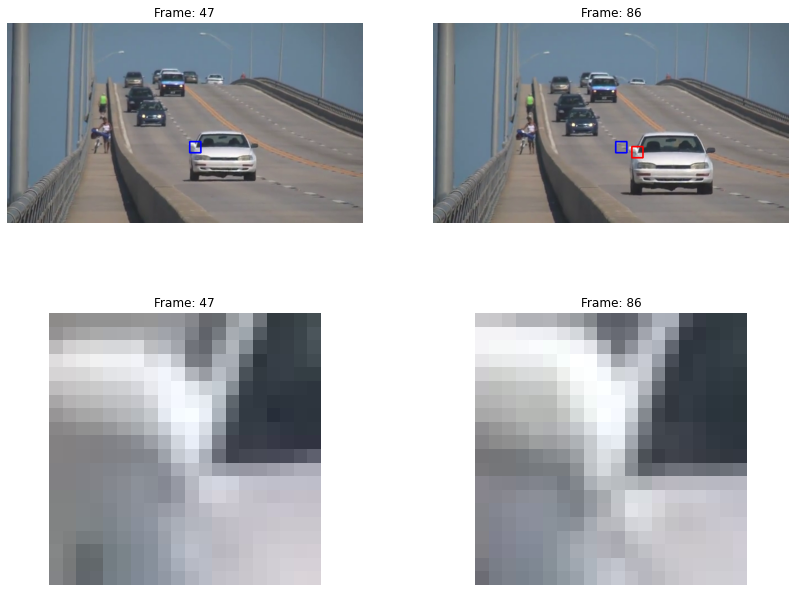

In [7]:
# @markdown 入力ファイル
in_file = "slow_traffic.mp4"  # @param {type: "string"}
# @markdown 処理を行うフレームの時間
t = 47  # @param {type: "slider", min: 0, max: 1000, step:1}
# @markdown 前後を見るフレームの間隔
t_offset = 39  # @param {type: "slider", min: 0, max: 50, step:1}
# @markdown 特徴点を追う位置
p_x = 0.53  # @param {type: "slider", min: 0.0, max: 1.0, step:0.01}
p_y = 0.63  # @param {type: "slider", min: 0.0, max: 1.0, step:0.01}

cap = cv2.VideoCapture(in_file)

num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# ターゲットフレームの読み込み
for i in progress_bar(range(num_frames)):
    ret, I2 = cap.read()

    if ret == False:
        break

    I2 = np.float32(cv2.cvtColor(I2, cv2.COLOR_BGR2RGB)) / 255.0

    if i == t:
        I1 = np.array(I2)

    if i == (t+t_offset):
        break

cap.release()

h_t = 20
w_t = 20

h, w = I1.shape[:2]
p_x = int(p_x * (w-1 - h_t))
p_y = int(p_y * (h-1 - w_t))

T1 = np.array(I1[p_y:p_y+h_t, p_x:p_x+w_t, :])

p_min = (p_x, p_y)
p_max = (p_x+w_t, p_y+h_t)

res = cv2.matchTemplate(I2, T1, cv2.TM_CCOEFF)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

q_min = max_loc
q_x = q_min[0]
q_y = q_min[1]
q_max = (q_min[0] + w_t, q_min[1] + h_t)

T2 = np.array(I2[q_y:q_y+h_t, q_x:q_x+w_t, :])

I1_rect = cv2.rectangle(I1, p_min, p_max, (0, 0, 255), 2)
I2_rect = cv2.rectangle(I2, p_min, p_max, (0, 0, 255), 2)
I2_rect = cv2.rectangle(I2_rect, q_min, q_max, (255, 0, 0), 2)


fig = plt.figure(figsize=(14, 11))
plt.subplot(2, 2, 1)
plt.imshow(I1_rect)
plt.axis('off')
plt.title("Frame: {0}".format(t))

plt.subplot(2, 2, 2)
plt.imshow(I2)
plt.axis('off')
plt.title("Frame: {0}".format(t+t_offset))

plt.subplot(2, 2, 3)
plt.imshow(T1)
plt.axis('off')
plt.title("Frame: {0}".format(t))

plt.subplot(2, 2, 4)
plt.imshow(T2)
plt.axis('off')
plt.title("Frame: {0}".format(t+t_offset))
